# Importing Necessary Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Connecting to the database

In [499]:
# Connect to the SQLite database
conn = sqlite3.connect('data/agri.db')

# Get the list of tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print("Tables in the database:")
print(tables)

Tables in the database:
        name
0  farm_data


# Initial Overview of Data

Display the information of the dataset before cleaning and transforming

In [500]:
query = f"SELECT * FROM farm_data;"
df = pd.read_sql_query(query, conn)

# Display the first 5 rows
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Display the dimensions of the dataset
print(f"\nDataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns")

# Check column names and data types
print("\nColumn information:")
print(df.dtypes)


First 5 rows of the dataset:


,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000



Dataset dimensions: 57489 rows and 15 columns

Column information:
System Location Code             object
Previous Cycle Plant Type        object
Plant Type                       object
Plant Stage                      object
Temperature Sensor (°C)         float64
Humidity Sensor (%)             float64
Light Intensity Sensor (lux)    float64
CO2 Sensor (ppm)                  int64
EC Sensor (dS/m)                float64
O2 Sensor (ppm)                   int64
Nutrient N Sensor (ppm)          object
Nutrient P Sensor (ppm)          object
Nutrient K Sensor (ppm)          object
pH Sensor                       float64
Water Level Sensor (mm)         float64
dtype: object


# Display unique values in categorical columns

This is to check for inconsistencies like spellings or capitalisations. 

In [501]:
print("\nSystem Location Code:", df['System Location Code'].unique())
print("\nPrevious Cycle Plant Type:", df['Previous Cycle Plant Type'].unique())
print("\nPlant Type:", df['Plant Type'].unique())
print("\nPlant Stage:", df['Plant Stage'].unique())


System Location Code: ['Zone_D' 'Zone_G' 'Zone_F' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']

Previous Cycle Plant Type: ['Herbs' 'Vine Crops' 'Leafy Greens' 'Fruiting Vegetables']

Plant Type: ['Vine Crops' 'VINE CROPS' 'herbs' 'fruiting vegetables' 'LEAFY GREENS'
 'FRUITING VEGETABLES' 'Leafy Greens' 'Herbs' 'Fruiting Vegetables'
 'HERBS' 'vine crops' 'leafy greens']

Plant Stage: ['Maturity' 'Vegetative' 'maturity' 'seedling' 'MATURITY' 'Seedling'
 'SEEDLING' 'VEGETATIVE' 'vegetative']


# Cleaning and Transforming 

From the data above, we can see that the plant type and plant stage columns have inconsistencies in capitalisation. We will first standardise the naming conventions to ensure the same category is not treated as different. Additionally, we will combine the plant type and stage columns to address the problem statement which is to predict the combined Plant Type-Stage. 

In [502]:
# Standardize categorical variables
df['Plant Type'] = df['Plant Type'].str.strip().str.title()
df['Plant Stage'] = df['Plant Stage'].str.strip().str.title()
df['Previous Cycle Plant Type'] = df['Previous Cycle Plant Type'].str.strip().str.title()

# Check the results of standardization
print("\nPlant Type:", sorted(df['Plant Type'].unique()))
print("\nPlant Stage:", sorted(df['Plant Stage'].unique()))
print("\nPrevious Cycle Plant Type:", sorted(df['Previous Cycle Plant Type'].unique()))

# Create the combined Plant Type-Stage column for classification task
df['Plant Type-Stage'] = df['Plant Type'] + " - " + df['Plant Stage']


Plant Type: ['Fruiting Vegetables', 'Herbs', 'Leafy Greens', 'Vine Crops']

Plant Stage: ['Maturity', 'Seedling', 'Vegetative']

Previous Cycle Plant Type: ['Fruiting Vegetables', 'Herbs', 'Leafy Greens', 'Vine Crops']


For System Location Code and Previous Cycle Plant Type, I implemented one-hot encoding since these are nominal variables with no inherent ranking between categories. For Plant Stage, I recognized its natural progression from Seedling to Vegetative to Maturity, so I applied ordinal encoding (0, 1, 2) to preserve this meaningful sequence. I then created interaction features combining Plant Type with Stage, which captures both which plant is being grown and its developmental phase simultaneously. This fulfills the requirement to predict the combined Plant Type-Stage while maintaining the ordinal relationship within stages and the nominal relationship between plant types

In [503]:
# One-hot encoding for nominal categorical variables
location_encoded = pd.get_dummies(df['System Location Code'], prefix='Location')
prev_plant_encoded = pd.get_dummies(df['Previous Cycle Plant Type'], prefix='PrevPlant')

# For the combined Plant Type-Stage approach
plant_type_encoded = pd.get_dummies(df['Plant Type'], prefix='PlantType')

# Ordinal encode Plant Stage starting from 1 (not 0)
stage_order = {'Seedling': 1, 'Vegetative': 2, 'Maturity': 3}
df['Stage_Ordinal'] = df['Plant Stage'].map(stage_order)

# Creates features
plant_type_stage_features = {}
for plant_type in df['Plant Type'].unique():
    col_name = f'PlantType_{plant_type}_Stage'
    plant_type_stage_features[col_name] = (
        (df['Plant Type'] == plant_type) * df['Stage_Ordinal']
    )

# Convert these features to a DataFrame
plant_type_stage_df = pd.DataFrame(plant_type_stage_features)

# Combine everything
numerical_columns = [col for col in df.columns if col not in [
    'System Location Code', 'Previous Cycle Plant Type',
    'Plant Type', 'Plant Stage', 'Plant Type-Stage', 'Stage_Ordinal']]
df = pd.concat([
    df[numerical_columns],
    location_encoded,
    prev_plant_encoded,
    plant_type_stage_df
], axis=1)

# Ensure all object or boolean columns are converted to numerical
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)       
pd.set_option('display.max_colwidth', 20)   
display(df.head())

,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Location_Zone_A,Location_Zone_B,Location_Zone_C,Location_Zone_D,Location_Zone_E,Location_Zone_F,Location_Zone_G,PrevPlant_Fruiting Vegetables,PrevPlant_Herbs,PrevPlant_Leafy Greens,PrevPlant_Vine Crops,PlantType_Vine Crops_Stage,PlantType_Herbs_Stage,PlantType_Fruiting Vegetables_Stage,PlantType_Leafy Greens_Stage
0,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346,0,0,0,1,0,0,0,0,1,0,0,3,0,0,0
1,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0
2,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000,0,0,0,0,0,1,0,0,1,0,0,0,3,0,0
3,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0
4,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


# Data Type Conversion

From the initial overview of the dataset, we can see that the nutrient column data types were treated as object. Therefore, we will be converting them to float.

In [504]:
# Nutrient N - Convert to string, replace None, remove ppm text, convert to numeric
df['Nutrient N Sensor (ppm)'] = df['Nutrient N Sensor (ppm)'].astype(str)
df['Nutrient N Sensor (ppm)'] = df['Nutrient N Sensor (ppm)'].replace('None', np.nan)
df['Nutrient N Sensor (ppm)'] = df['Nutrient N Sensor (ppm)'].str.replace('ppm', '').str.strip()
df['Nutrient N Sensor (ppm)'] = pd.to_numeric(df['Nutrient N Sensor (ppm)'], errors='coerce')

# Nutrient P - Convert to string, replace None, remove ppm text, convert to numeric
df['Nutrient P Sensor (ppm)'] = df['Nutrient P Sensor (ppm)'].astype(str)
df['Nutrient P Sensor (ppm)'] = df['Nutrient P Sensor (ppm)'].replace('None', np.nan)
df['Nutrient P Sensor (ppm)'] = df['Nutrient P Sensor (ppm)'].str.replace('ppm', '').str.strip()
df['Nutrient P Sensor (ppm)'] = pd.to_numeric(df['Nutrient P Sensor (ppm)'], errors='coerce')

# Nutrient K - Convert to string, replace None, remove ppm text, convert to numeric
df['Nutrient K Sensor (ppm)'] = df['Nutrient K Sensor (ppm)'].astype(str)
df['Nutrient K Sensor (ppm)'] = df['Nutrient K Sensor (ppm)'].replace('None', np.nan)
df['Nutrient K Sensor (ppm)'] = df['Nutrient K Sensor (ppm)'].str.replace('ppm', '').str.strip()
df['Nutrient K Sensor (ppm)'] = pd.to_numeric(df['Nutrient K Sensor (ppm)'], errors='coerce')

# Verify the conversion
print("\nAfter conversion - data types:")
print(df[['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)']].dtypes)


After conversion - data types:
Nutrient N Sensor (ppm)    float64
Nutrient P Sensor (ppm)    float64
Nutrient K Sensor (ppm)    float64
dtype: object


# Display statistics for numerical columns

This is to check for outliers and missing values.

In [505]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

print("Negative Values:")
print((df[numeric_cols]<0).sum())

print("\nMissing Values:")
print(df[numeric_cols].isnull().sum())

print("\nDescriptive Statistics:")
print(df[numeric_cols].describe())

Negative Values:
Temperature Sensor (°C)                1252
Humidity Sensor (%)                       0
Light Intensity Sensor (lux)           1385
CO2 Sensor (ppm)                          0
EC Sensor (dS/m)                         14
O2 Sensor (ppm)                           0
Nutrient N Sensor (ppm)                   0
Nutrient P Sensor (ppm)                   0
Nutrient K Sensor (ppm)                   0
pH Sensor                                 0
Water Level Sensor (mm)                   0
Location_Zone_A                           0
Location_Zone_B                           0
Location_Zone_C                           0
Location_Zone_D                           0
Location_Zone_E                           0
Location_Zone_F                           0
Location_Zone_G                           0
PrevPlant_Fruiting Vegetables             0
PrevPlant_Herbs                           0
PrevPlant_Leafy Greens                    0
PrevPlant_Vine Crops                      0
PlantType_Vine 

# Handle Missing Values and Outliers in Temperature Column

From the previous cell, we can see that there are a total of 1252 negative values which attribute to about 2.6% of the dataset. I made the assumption that these negative values were probably keyed in wrongly and therefore should be treated as positive instead.

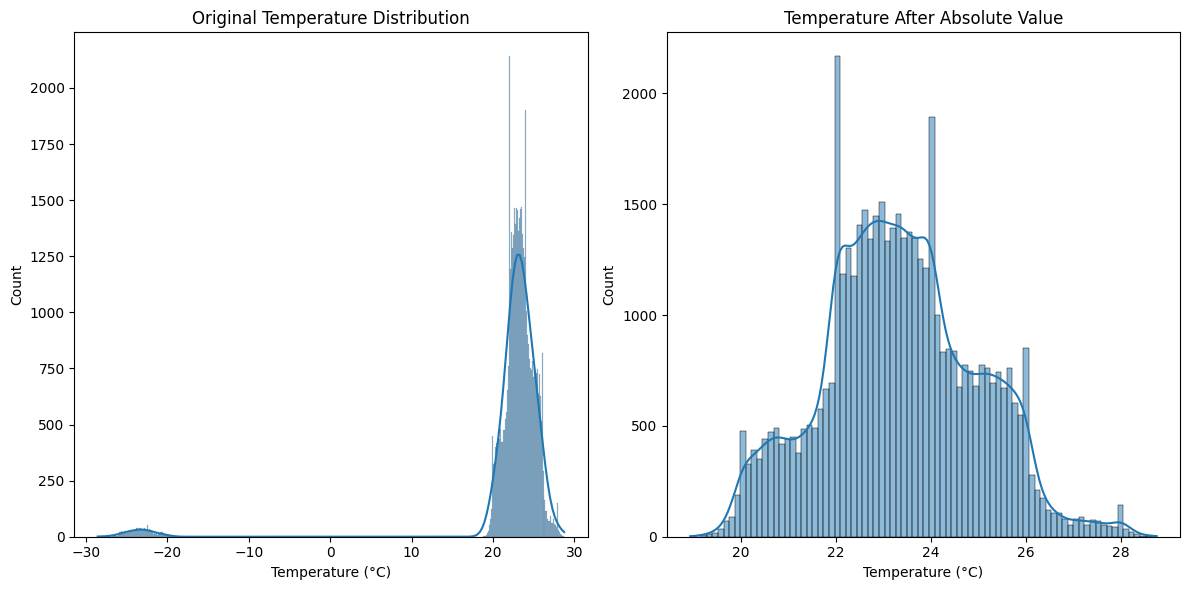

In [506]:
# Create a copy of the original temperature column
df['Temperature_Original'] = df['Temperature Sensor (°C)'].copy()

# Convert negative values to positive
df['Temperature_Abs'] = df['Temperature Sensor (°C)'].abs()

# Analyze the distribution after converting negatives
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Temperature_Original'].dropna(), kde=True)
plt.title('Original Temperature Distribution')
plt.xlabel('Temperature (°C)')

plt.subplot(1, 2, 2)
sns.histplot(df['Temperature_Abs'].dropna(), kde=True)
plt.title('Temperature After Absolute Value')
plt.xlabel('Temperature (°C)')
plt.tight_layout()
plt.show()

The original data shows a bimodal pattern with a main cluster centered around 22-24°C and a smaller problematic cluster at approximately -20°C, suggesting recording errors. After applying the absolute value transformation, we see a broader, more irregular distribution ranging from 20-28°C with notable concentration peaks at 22°C and 24°C. This multi-modal, non-symmetric pattern justifies using median imputation for the missing values, as the median better represents the typical operating temperature of the environment. Given this complex distribution pattern, the median provides a more stable and representative central value than the mean.

Median temperature (after abs transformation): 23.27°C

Summary after transformation and median imputation:
count    57489.000000
mean        23.326396
std          1.490767
min         18.930000
25%         22.440000
50%         23.270000
75%         24.110000
max         28.750000
Name: Temperature_Sensor_Clean, dtype: float64

Remaining missing values: 0


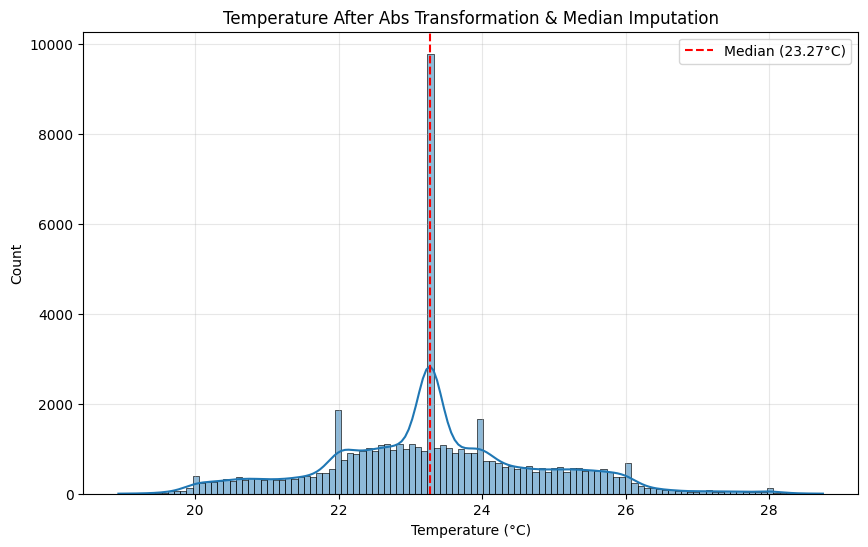

In [507]:
# Create a copy of the original temperature column
df['Temperature_Original'] = df['Temperature Sensor (°C)'].copy()

# Calculate the median of the transformed values 
temp_median = df['Temperature_Abs'].median()
print(f"Median temperature (after abs transformation): {temp_median:.2f}°C")

# Fill missing values with the median and drop the original columns
df['Temperature_Sensor_Clean'] = df['Temperature_Abs'].fillna(temp_median)
df.drop(columns=['Temperature Sensor (°C)', 'Temperature_Abs', 'Temperature_Original'], inplace=True)

# Print summary statistics after transformation and imputation
print("\nSummary after transformation and median imputation:")
print(df['Temperature_Sensor_Clean'].describe())

# Verify no remaining missing values
missing_after = df['Temperature_Sensor_Clean'].isna().sum()
print(f"\nRemaining missing values: {missing_after}")

# Final visualization to confirm the result
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature_Sensor_Clean'], kde=True)
plt.title('Temperature After Abs Transformation & Median Imputation')
plt.xlabel('Temperature (°C)')
plt.axvline(x=temp_median, color='red', linestyle='--', 
            label=f'Median ({temp_median:.2f}°C)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Handle Missing Values in Humidity Column

By creating a comprehensive correlation matrix of the encoded features, I could identify significant relationships between variables that would enable more accurate imputation of missing values. This targeted approach ensures that my imputations preserve the underlying patterns in the agricultural sensor data, resulting in a more reliable dataset for subsequent modeling of temperature conditions and plant type-stage classification.

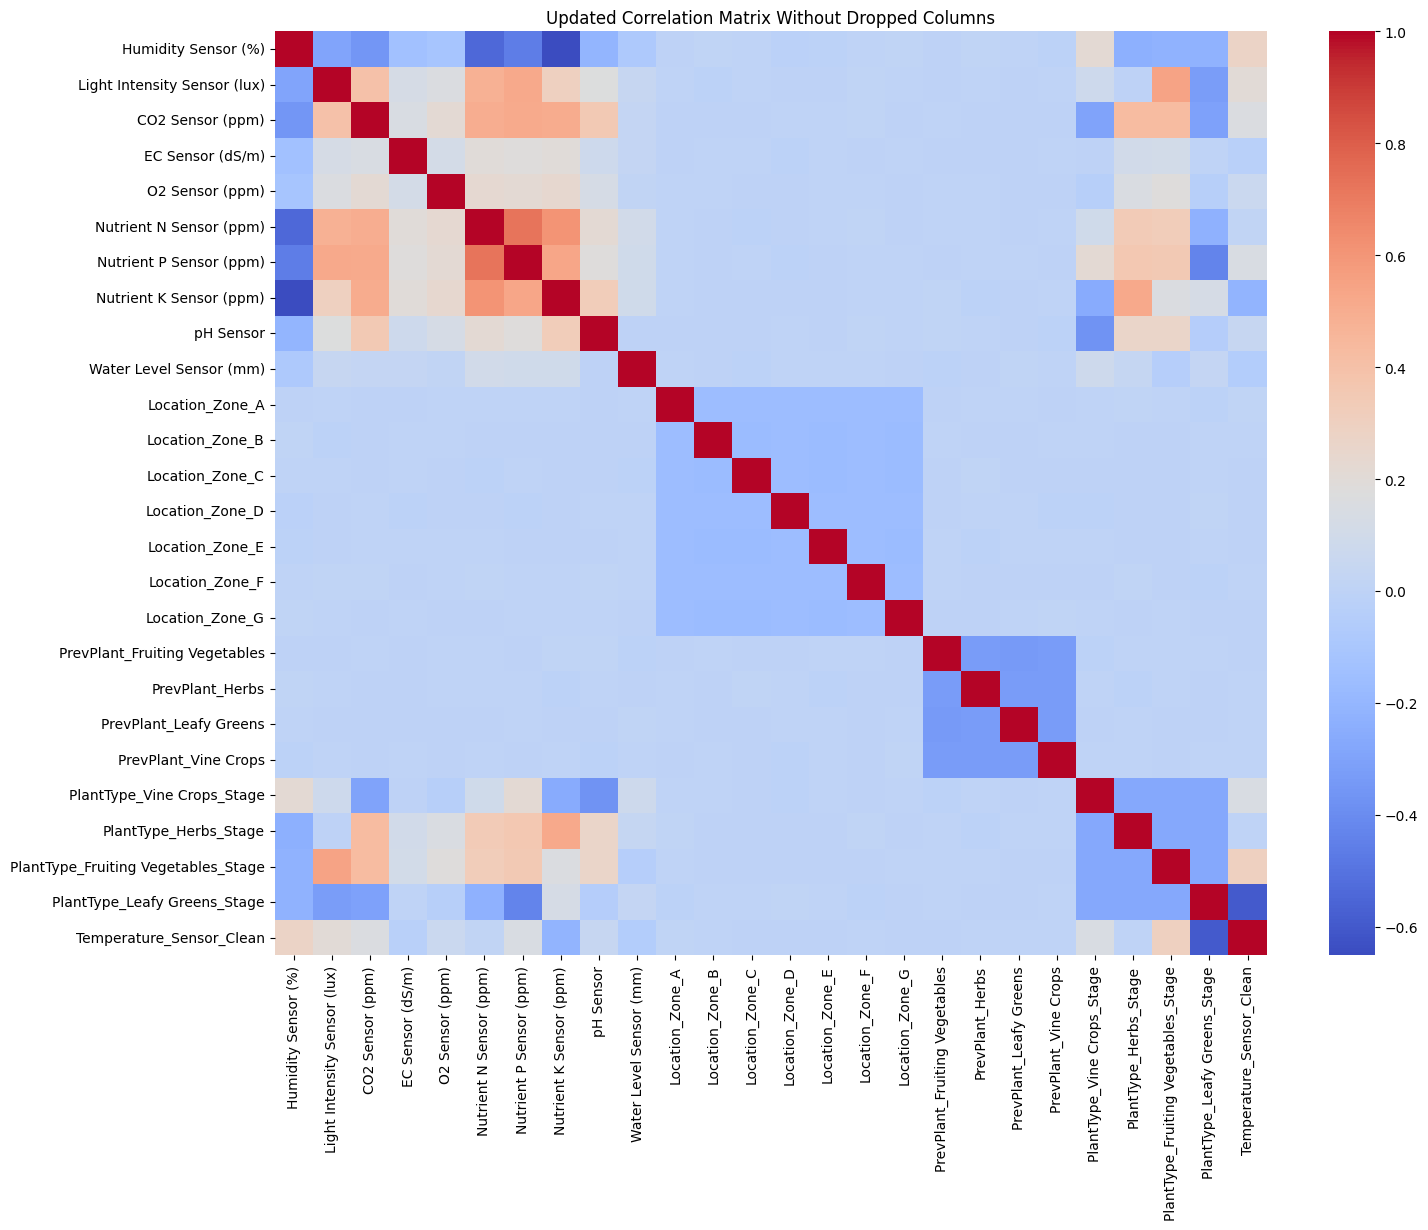

In [508]:
# Visualize the updated correlation map
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Updated Correlation Matrix Without Dropped Columns")
plt.show()

The heatmap shows no strong positive correlations between Humidity Sensor and other features. Therefore, I decided to use median imputation once again as a more complex imputation method like KNN would likely not provide significant improvements.

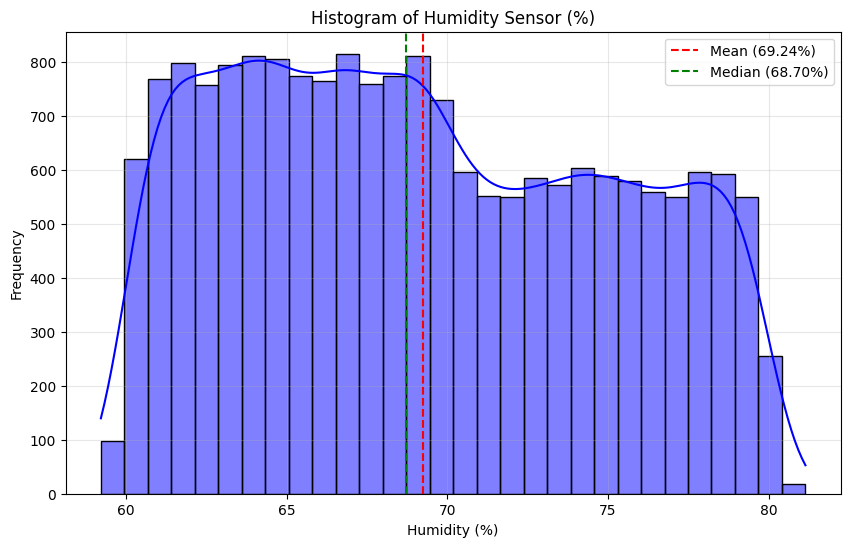

In [509]:
# Visualize the histogram distribution of Humidity Sensor (%)
plt.figure(figsize=(10, 6))
sns.histplot(df['Humidity Sensor (%)'], kde=True, color='blue', bins=30)
plt.title('Histogram of Humidity Sensor (%)')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.axvline(df['Humidity Sensor (%)'].mean(), color='red', linestyle='--', label=f'Mean ({df['Humidity Sensor (%)'].mean():.2f}%)')
plt.axvline(df['Humidity Sensor (%)'].median(), color='green', linestyle='--', label=f'Median ({df['Humidity Sensor (%)'].median():.2f}%)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

I decided to use group median imputation to leverage on the spatial context through zone-based grouping. I made the assumption that humidity conditions are likely to be more similar within the same growing zone than across different zones and this will give a better representation for the missing values.

Remaining missing values after grouped median imputation: 0


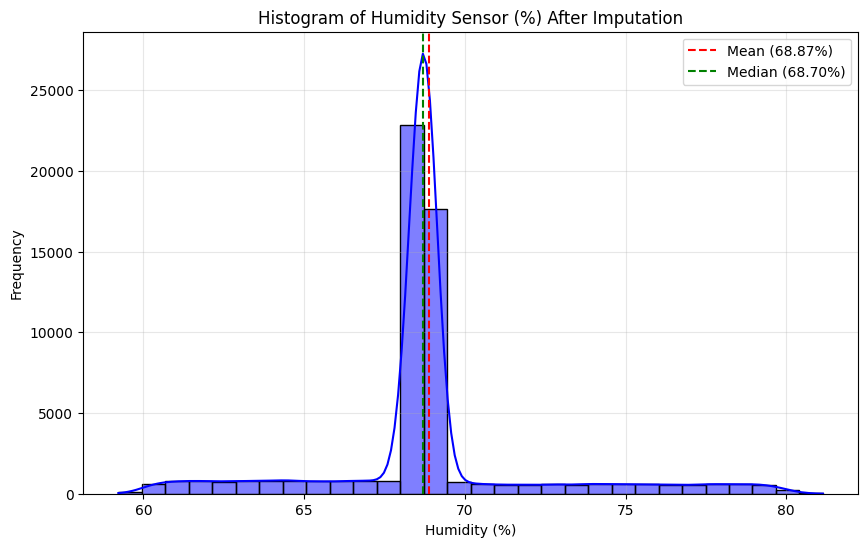

In [510]:
# Define a function to impute missing values with the median grouped by encoded columns
def impute_median_grouped(df, group_cols, target_col):
    df[target_col] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.fillna(x.median())
    )
    return df

# Apply the grouped median imputation using zones
group_cols = [
    'Location_Zone_A', 'Location_Zone_B', 'Location_Zone_C', 
    'Location_Zone_D', 'Location_Zone_E', 'Location_Zone_F', 'Location_Zone_G'
]
df = impute_median_grouped(df, group_cols, 'Humidity Sensor (%)')

# Verify no remaining missing values
missing_after = df['Humidity Sensor (%)'].isna().sum()
print(f"Remaining missing values after grouped median imputation: {missing_after}")

# Visualize the histogram distribution of Humidity Sensor (%) after imputation
plt.figure(figsize=(10, 6))
sns.histplot(df['Humidity Sensor (%)'], kde=True, color='blue', bins=30)
plt.title('Histogram of Humidity Sensor (%) After Imputation')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.axvline(df['Humidity Sensor (%)'].mean(), color='red', linestyle='--', label=f'Mean ({df["Humidity Sensor (%)"].mean():.2f}%)')
plt.axvline(df['Humidity Sensor (%)'].median(), color='green', linestyle='--', label=f'Median ({df["Humidity Sensor (%)"].median():.2f}%)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Handle Missing Values and Outliers in Light Column

Similar to handling the negative values for temperature, I made the assumption that the values were probably keyed wrongly as there is no such thing as negative lux.

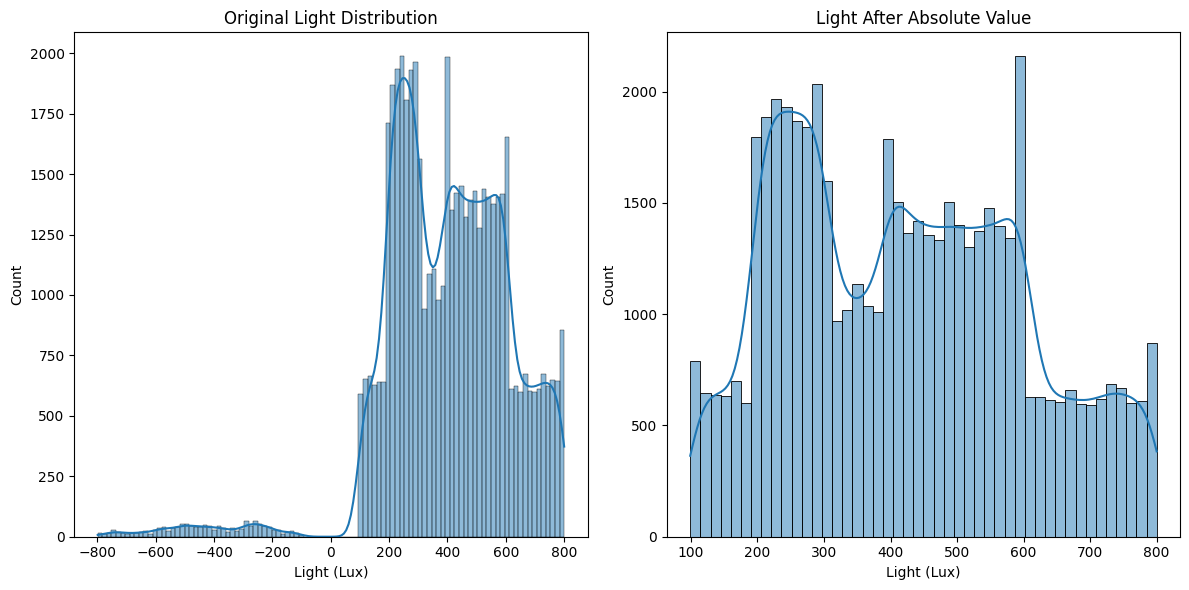

In [511]:
# Create a copy of the original light column
df['Light_Original'] = df['Light Intensity Sensor (lux)'].copy()

# Convert negative values to positive
df['Light_Abs'] = df['Light Intensity Sensor (lux)'].abs()

# Analyze the distribution after converting negatives
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Light_Original'].dropna(), kde=True)
plt.title('Original Light Distribution')
plt.xlabel('Light (Lux)')

plt.subplot(1, 2, 2)
sns.histplot(df['Light_Abs'].dropna(), kde=True)
plt.title('Light After Absolute Value')
plt.xlabel('Light (Lux)')
plt.tight_layout()
plt.show()

The resulting bimodal distribution, with peaks around 250 lux and 500 lux, likely represents different lighting conditions across growing zones or times of day. For imputing missing light intensity values, median imputation is appropriate since the transformed distribution shows clear central tendencies within what appear to be distinct lighting scenarios. Using the median rather than mean would better preserve these natural lighting patterns by being less sensitive to the extreme values still present in the data.

Median light (after abs transformation): 411.00°C

Summary after transformation and median imputation:
count    57489.000000
mean       419.017012
std        171.730616
min         99.000000
25%        274.000000
50%        411.000000
75%        544.000000
max        800.000000
Name: Light_Intensity_Clean, dtype: float64

Remaining missing values: 0


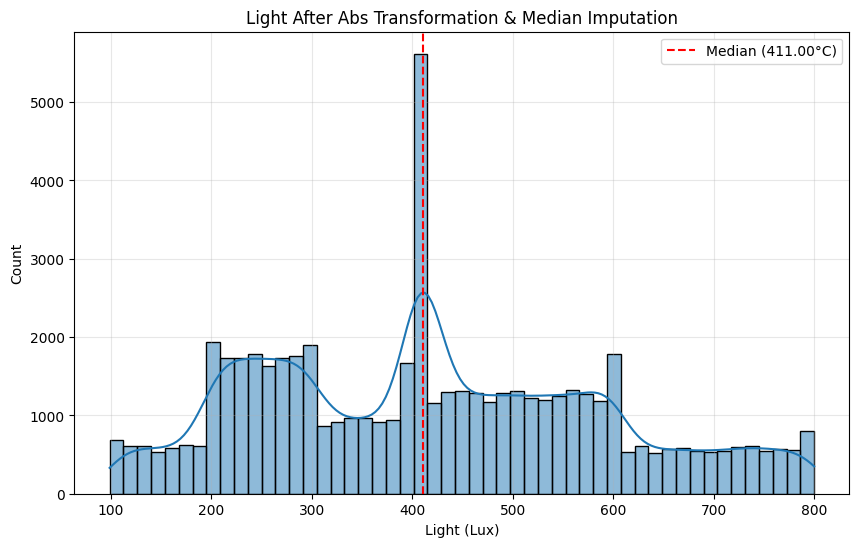

In [512]:
# Create a copy of the original light column
df['Light_Original'] = df['Light Intensity Sensor (lux)'].copy()

# Calculate the median of the transformed values 
light_median = df['Light_Abs'].median()
print(f"Median light (after abs transformation): {light_median:.2f}°C")

# Fill missing values with the median and drop the original columns
df['Light_Intensity_Clean'] = df['Light_Abs'].fillna(light_median)
df.drop(columns=['Light Intensity Sensor (lux)', 'Light_Abs', 'Light_Original'], inplace=True)

# Print summary statistics after transformation and imputation
print("\nSummary after transformation and median imputation:")
print(df['Light_Intensity_Clean'].describe())

# Verify no remaining missing values
missing_after = df['Light_Intensity_Clean'].isna().sum()
print(f"\nRemaining missing values: {missing_after}")

# Final visualization to confirm the result
plt.figure(figsize=(10, 6))
sns.histplot(df['Light_Intensity_Clean'], kde=True)
plt.title('Light After Abs Transformation & Median Imputation')
plt.xlabel('Light (Lux)')
plt.axvline(x=light_median, color='red', linestyle='--', 
            label=f'Median ({light_median:.2f}°C)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Handle Negative Values in EC Sensor

This histogram clearly illustrates that the 14 negative values are statistical outliers that likely represent measurement errors or data recording issues rather than valid observations. Removing these few negative values, just 0.025% of the dataset, is therefore justified and will ensure the integrity of our analysis without significantly impacting the overall distribution or statistical power of the dataset.

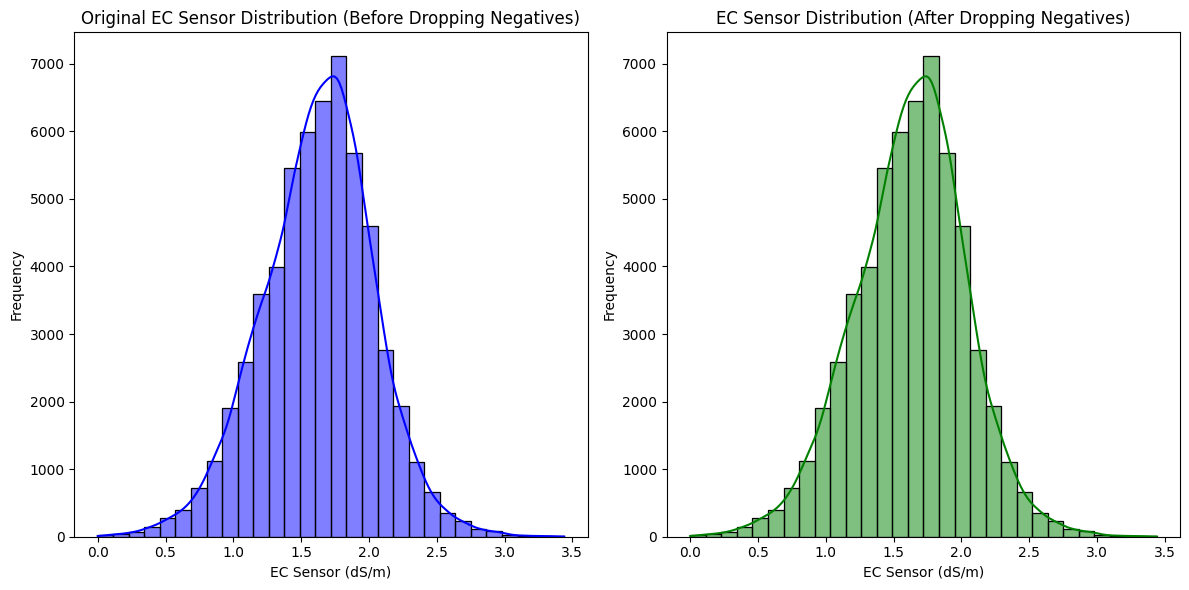

In [513]:
# Create a copy of the original EC Sensor column
df['EC_Original'] = df['EC Sensor (dS/m)'].copy()

# Drop rows where EC Sensor has negative values
df = df[df['EC Sensor (dS/m)'] >= 0]

# Analyze the distribution before and after dropping negatives
plt.figure(figsize=(12, 6))

# Plot the original distribution
plt.subplot(1, 2, 1)
sns.histplot(df['EC_Original'].dropna(), kde=True, color='blue', bins=30)
plt.title('Original EC Sensor Distribution (Before Dropping Negatives)')
plt.xlabel('EC Sensor (dS/m)')
plt.ylabel('Frequency')

# Plot the cleaned distribution
plt.subplot(1, 2, 2)
sns.histplot(df['EC Sensor (dS/m)'].dropna(), kde=True, color='green', bins=30)
plt.title('EC Sensor Distribution (After Dropping Negatives)')
plt.xlabel('EC Sensor (dS/m)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Drop the EC_Original column after comparison
df.drop(columns=['EC_Original'], inplace=True)

# Handle the remaining missing values

At first, I assumed that the missing values could be 0 and the farmer wanted to test if the nutrients did help with the growth of the plants. However, based on the visualizations of nutrient sensor data, there appears to be a clear distinction between true zero values and missing data. The left column histograms show large spikes at zero for all sensors, creating strongly bimodal distributions that are unlikely to represent natural measurement variation.

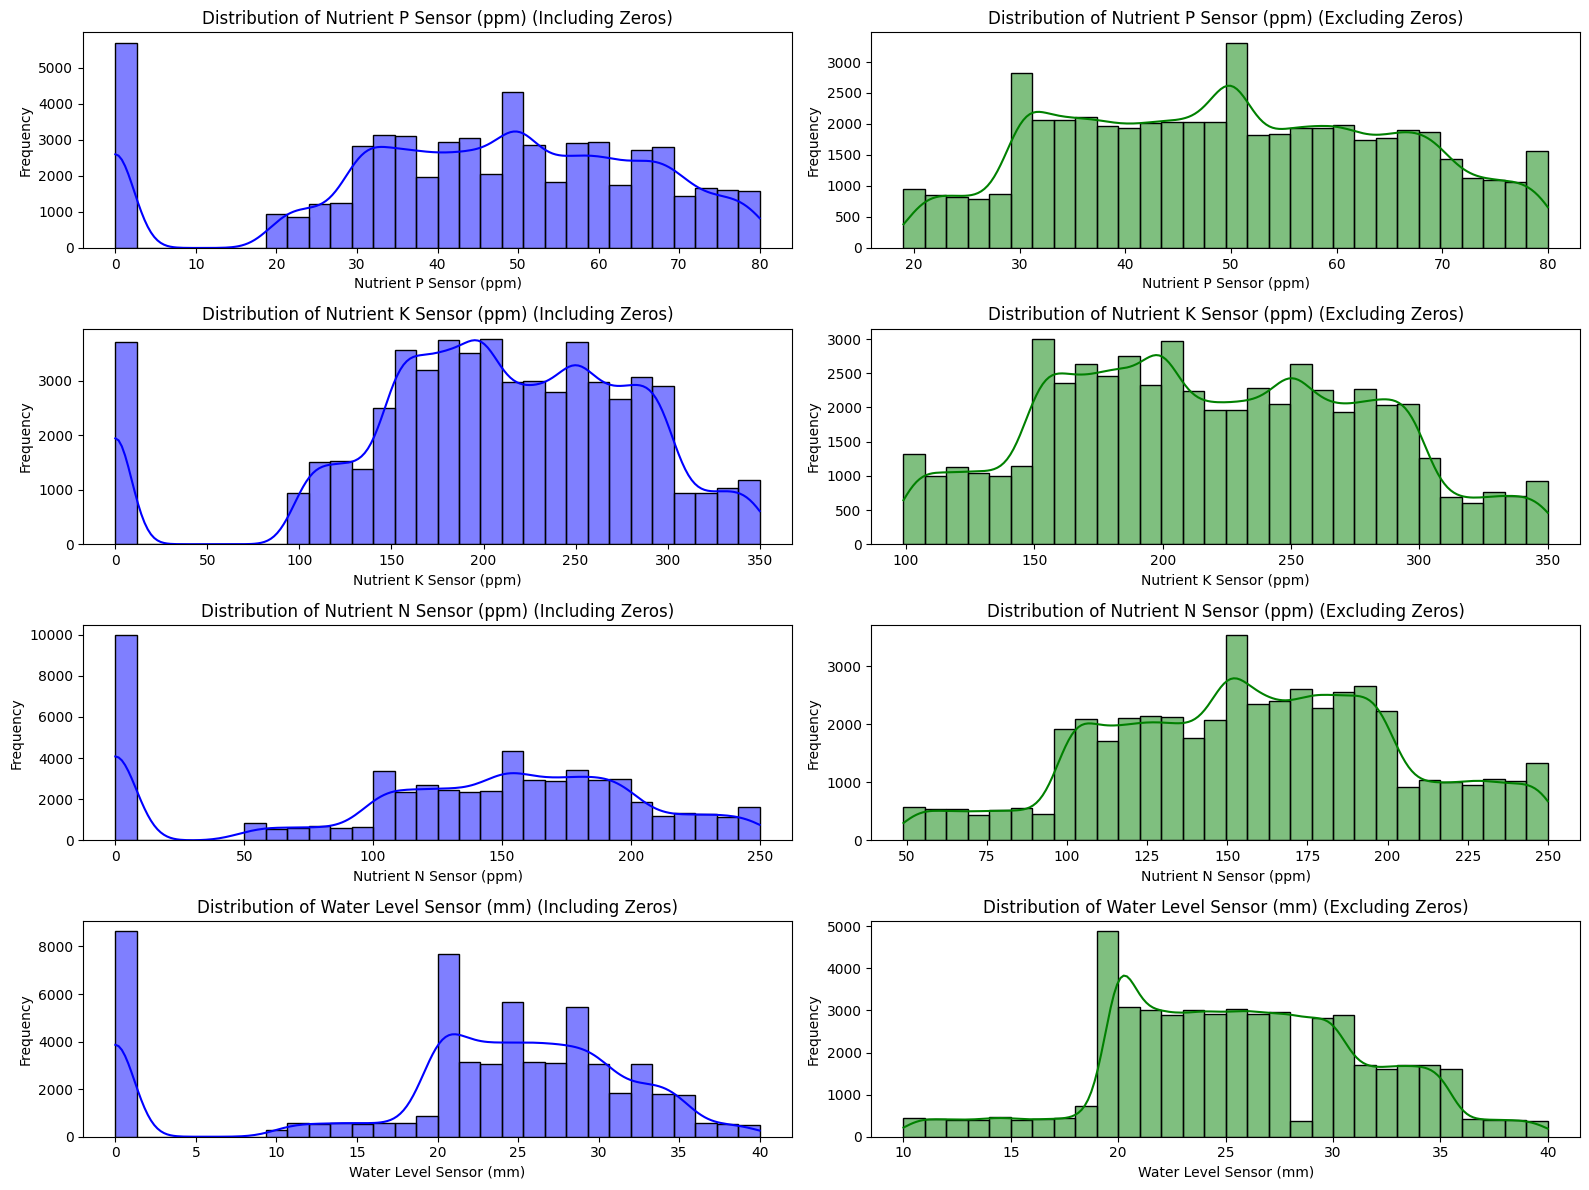

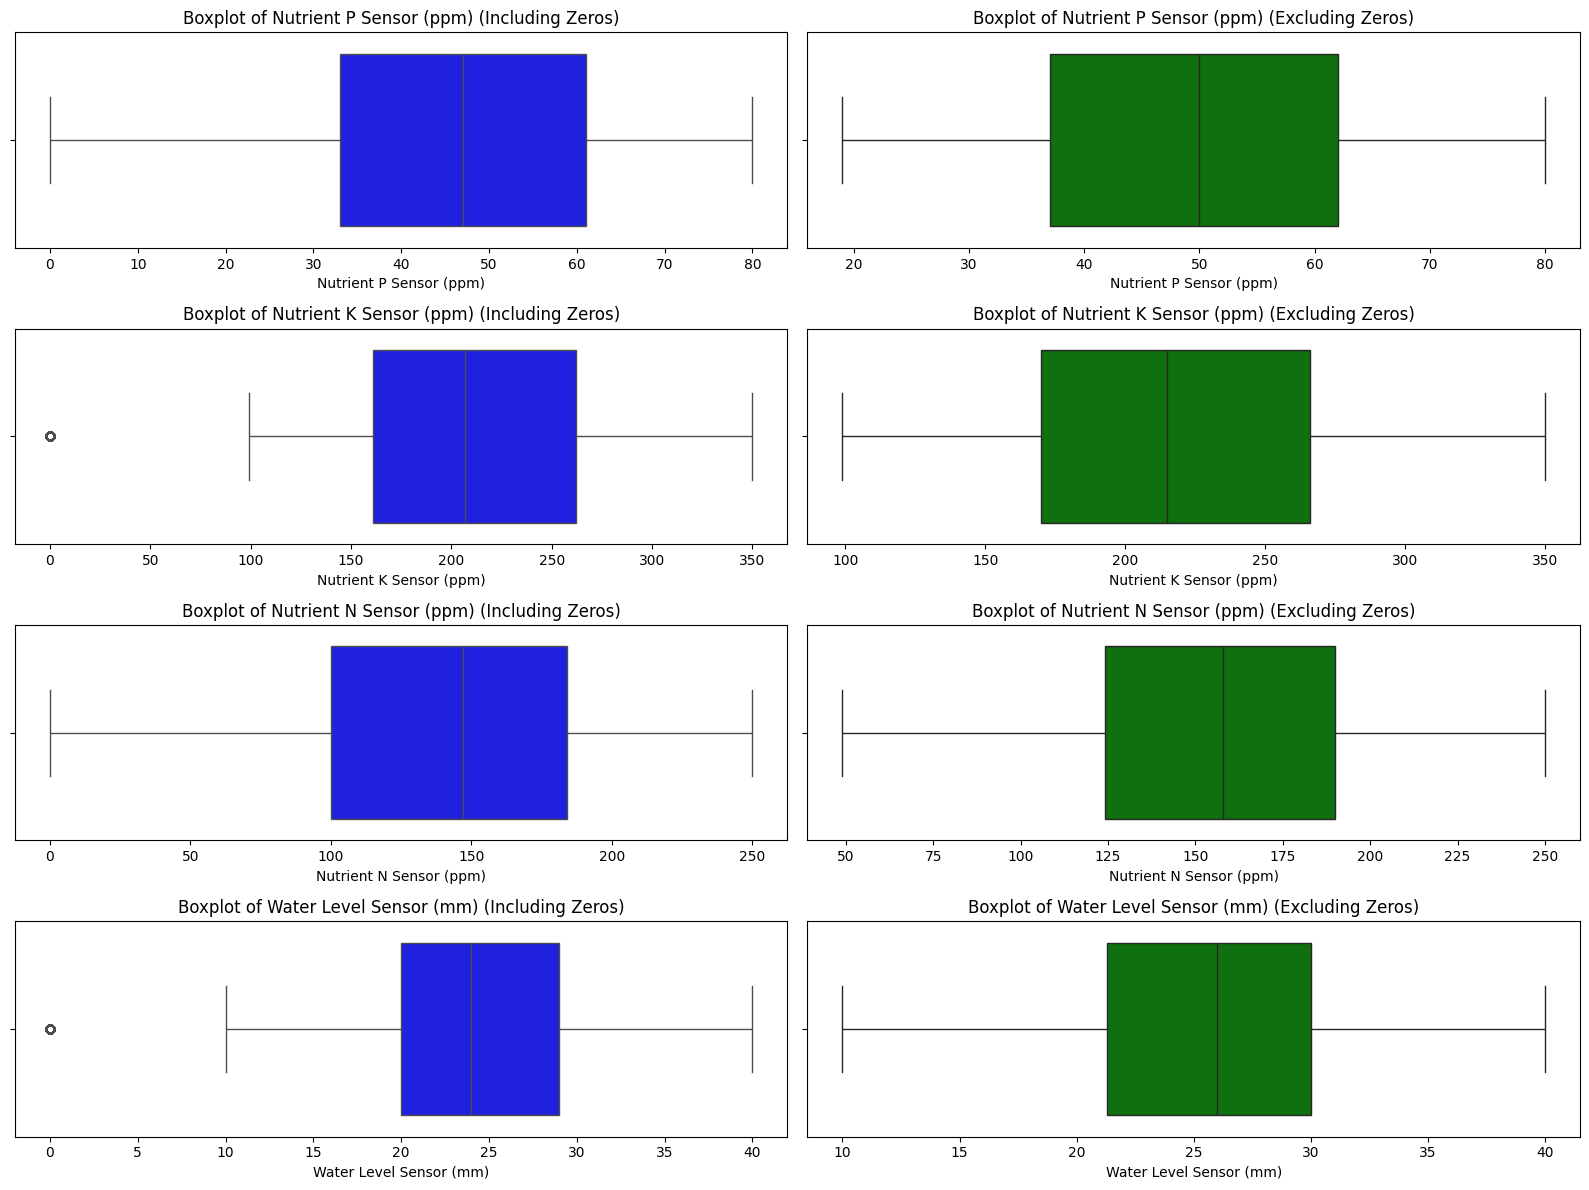

In [514]:
# Temporarily replace missing values with zeros for visualization
df_temp = df.copy()
df_temp[['Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Water Level Sensor (mm)']] = df_temp[['Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Water Level Sensor (mm)']].fillna(0)

# Plot histograms for the columns with and without zeros
plt.figure(figsize=(16, 12))

columns_to_plot = ['Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Water Level Sensor (mm)']

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, 2*i-1)
    sns.histplot(df_temp[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col} (Including Zeros)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.subplot(4, 2, 2*i)
    sns.histplot(df_temp[df_temp[col] != 0][col], kde=True, bins=30, color='green')
    plt.title(f'Distribution of {col} (Excluding Zeros)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot boxplots for the columns with and without zeros
plt.figure(figsize=(16, 12))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, 2*i-1)
    sns.boxplot(x=df_temp[col], color='blue')
    plt.title(f'Boxplot of {col} (Including Zeros)')
    
    plt.subplot(4, 2, 2*i)
    sns.boxplot(x=df_temp[df_temp[col] != 0][col], color='green')
    plt.title(f'Boxplot of {col} (Excluding Zeros)')

plt.tight_layout()
plt.show()

The right column histograms excluding zeros reveal the true underlying distributions of each parameter, which appear more consistent with expected agricultural measurements. This suggests that treating missing values as zeros would be inappropriate and potentially misleading for modeling purposes, as it would artificially create a bimodal pattern that doesn't reflect the actual nutrient or water level relationships within the growing environment. Therefore, I decided to use median imputation to handle the missing values to preserve the bimodel distribution. 

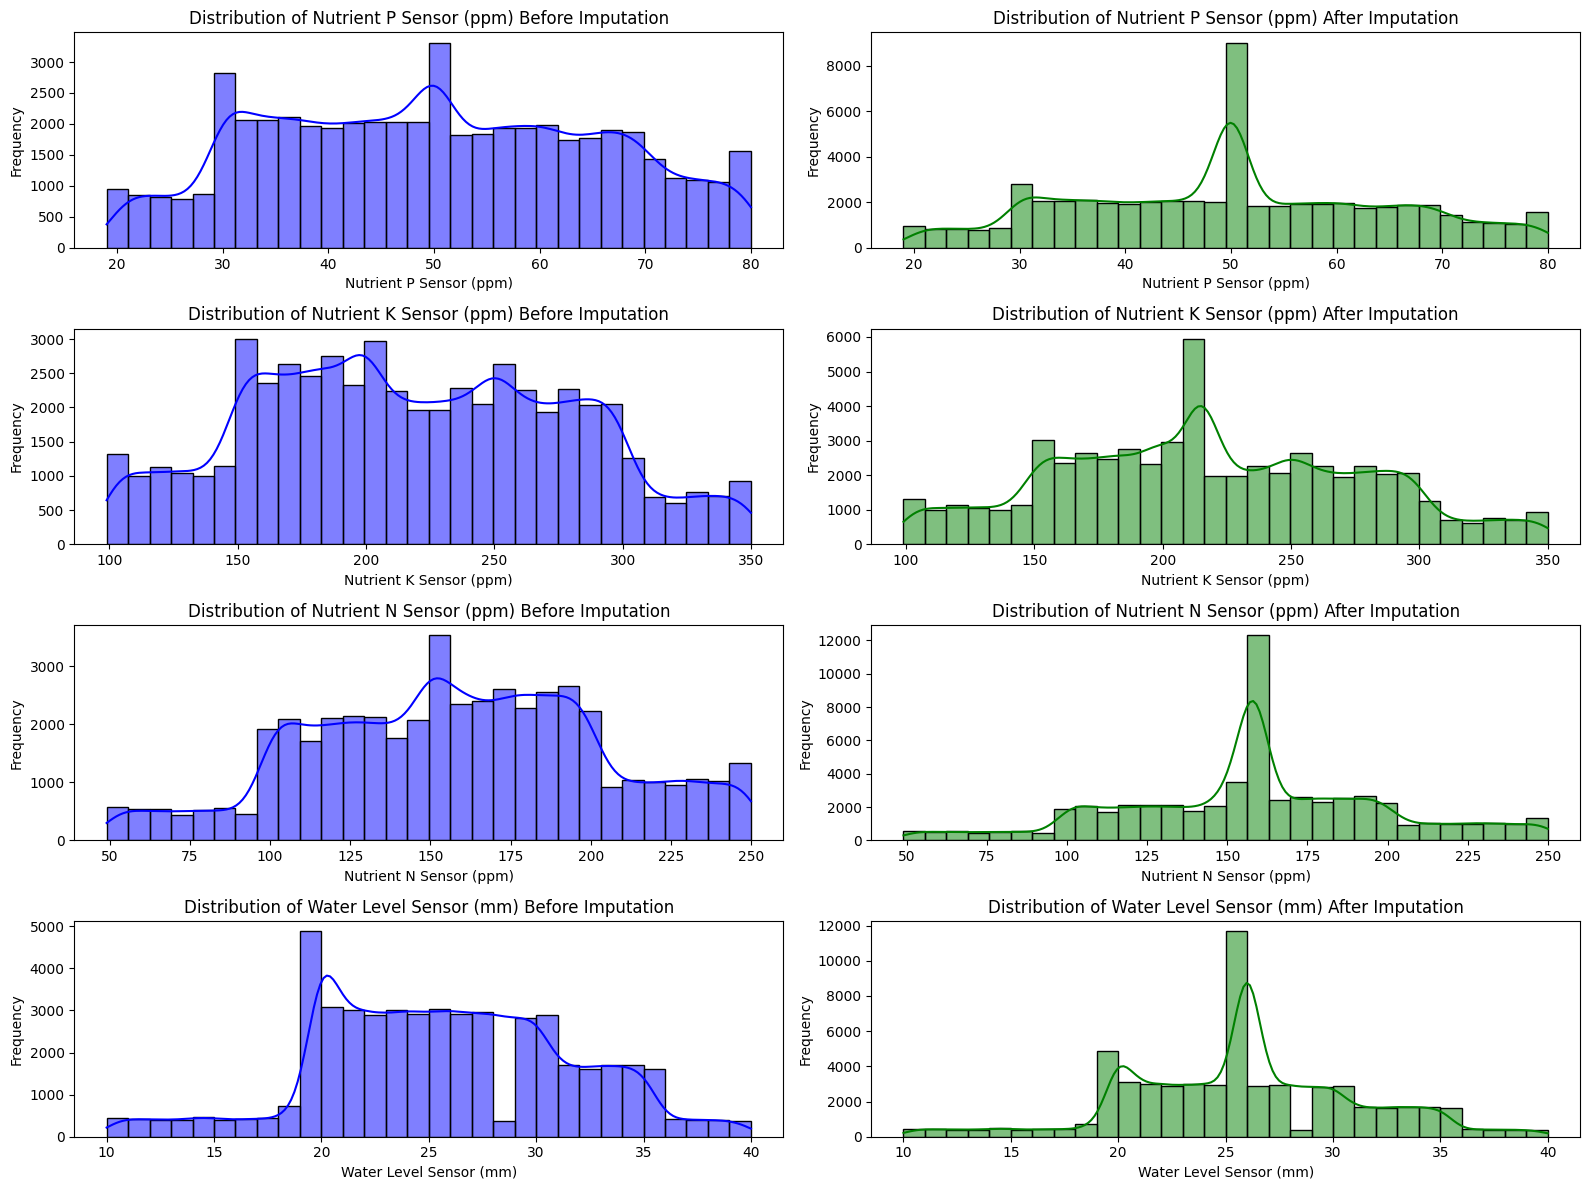

In [515]:
# Create a copy of the original DataFrame for visualization
df_before_imputation = df.copy()

# Median imputation for remaining missing values 
df = df.assign(
    **{
        'Nutrient P Sensor (ppm)': df['Nutrient P Sensor (ppm)'].fillna(df['Nutrient P Sensor (ppm)'].median()),
        'Nutrient K Sensor (ppm)': df['Nutrient K Sensor (ppm)'].fillna(df['Nutrient K Sensor (ppm)'].median()),
        'Nutrient N Sensor (ppm)': df['Nutrient N Sensor (ppm)'].fillna(df['Nutrient N Sensor (ppm)'].median()),
        'Water Level Sensor (mm)': df['Water Level Sensor (mm)'].fillna(df['Water Level Sensor (mm)'].median())
    }
)

# Plot histograms for the columns before and after imputation
columns_to_plot = ['Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Water Level Sensor (mm)']

plt.figure(figsize=(16, 12))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, 2*i-1)
    sns.histplot(df_before_imputation[col].dropna(), kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col} Before Imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.subplot(4, 2, 2*i)
    sns.histplot(df[col], kde=True, bins=30, color='green')
    plt.title(f'Distribution of {col} After Imputation')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Engineering

I began with correlation analysis to identify features that might have linear relationships with temperature. As seen in the correlation matrix, no features showed particularly strong linear correlations with temperature, with the strongest being Light_Intensity_Clean (r=0.258), PlantType_Fruiting_Vegetables_Stage (r=0.237), and PlantType_Leafy_Greens_Stage (r=-0.557).


Correlation of Temperature_Sensor_Clean with other features:
Temperature_Sensor_Clean               1.000000
PlantType_Fruiting Vegetables_Stage    0.299082
Light_Intensity_Clean                  0.258054
CO2 Sensor (ppm)                       0.157302
Humidity Sensor (%)                    0.155436
PlantType_Vine Crops_Stage             0.143214
Nutrient P Sensor (ppm)                0.138718
O2 Sensor (ppm)                        0.062667
pH Sensor                              0.043956
Nutrient N Sensor (ppm)                0.012632
Location_Zone_A                        0.007626
Location_Zone_B                        0.004090
PrevPlant_Leafy Greens                 0.003220
Location_Zone_F                        0.002902
PlantType_Herbs_Stage                  0.001044
PrevPlant_Vine Crops                   0.000892
PrevPlant_Herbs                        0.000855
Location_Zone_G                       -0.001657
Location_Zone_E                       -0.001881
PrevPlant_Fruiting Vegetab

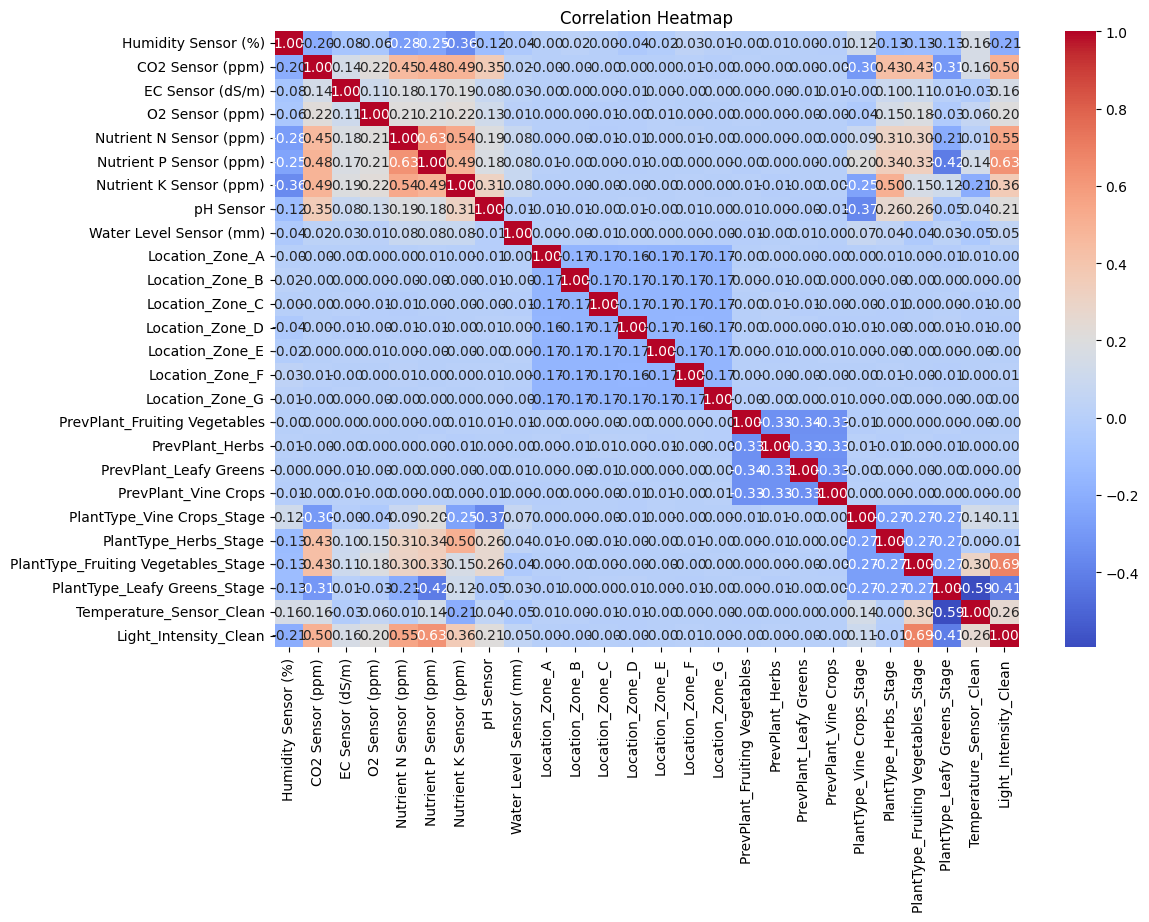

In [516]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Extract correlations for Temperature_Sensor_Clean
temperature_correlations = correlation_matrix['Temperature_Sensor_Clean']

# Sort correlations in descending order
temperature_correlations_sorted = temperature_correlations.sort_values(ascending=False)

# Display the sorted correlations
print("\nCorrelation of Temperature_Sensor_Clean with other features:")
print(temperature_correlations_sorted)

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

The scatter plots revealed why correlations alone were insufficient: the relationships weren't simply linear but showed distinct patterns and clusters. For example, Light_Intensity_Clean exhibited distinct bands rather than a continuous relationship, and the Plant Type-Stage variables showed discrete groupings that couldn't be adequately captured by correlation coefficients

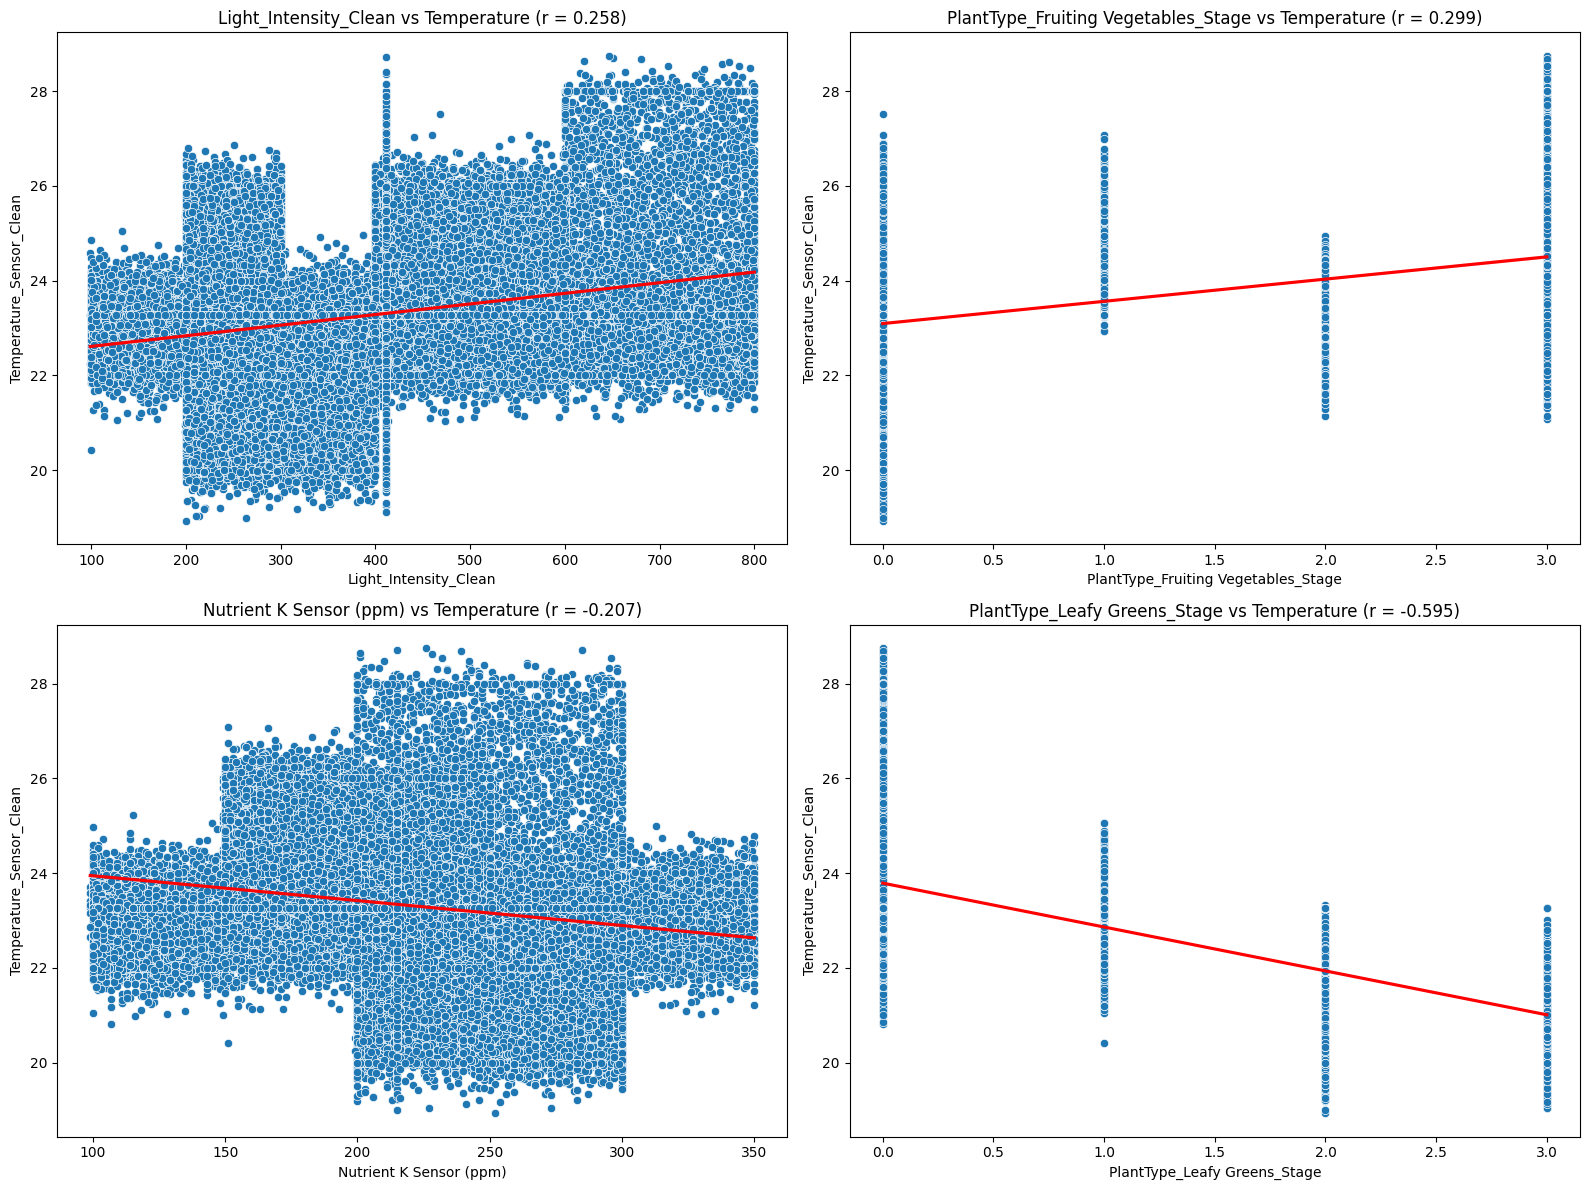

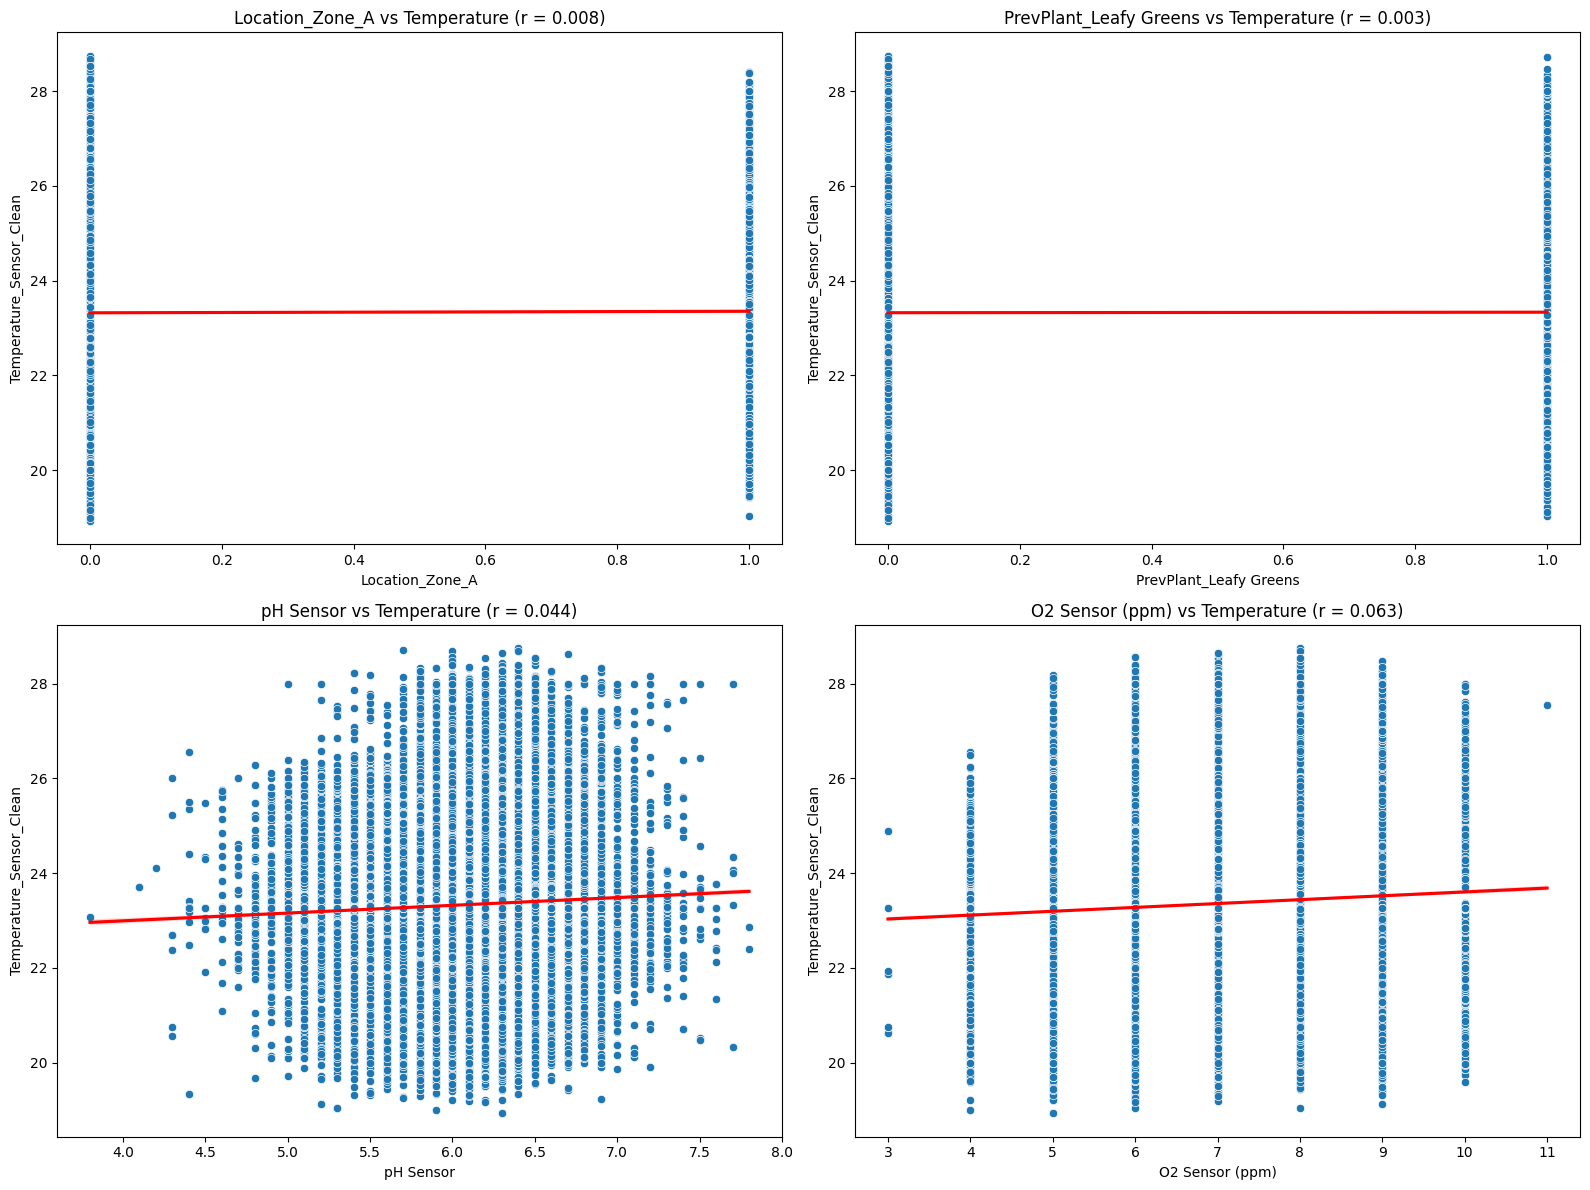

In [517]:
# Create a figure with subplots for your top 4 features
plt.figure(figsize=(16, 12))

# Features with strongest correlations (absolute value above 0.2)
top_features = [
    'Light_Intensity_Clean', 
    'PlantType_Fruiting Vegetables_Stage', 
    'Nutrient K Sensor (ppm)',
    'PlantType_Leafy Greens_Stage'
]

# Create a 2x2 grid of scatter plots
for i, feature in enumerate(top_features):
    plt.subplot(2, 2, i+1)
    
    # Create scatter plot
    sns.scatterplot(x=df[feature], y=df['Temperature_Sensor_Clean'])
    
    # Add regression line
    sns.regplot(x=df[feature], y=df['Temperature_Sensor_Clean'], 
                scatter=False, line_kws={"color": "red"})
    
    # Add correlation coefficient in the title
    corr = df[feature].corr(df['Temperature_Sensor_Clean'])
    plt.title(f'{feature} vs Temperature (r = {corr:.3f})', fontsize=12)
    
plt.tight_layout()
plt.show()

# For comparison, plot some weakly correlated features
plt.figure(figsize=(16, 12))

# Features with weak correlations
weak_features = [
    'Location_Zone_A', 
    'PrevPlant_Leafy Greens', 
    'pH Sensor',
    'O2 Sensor (ppm)'
]

# Create a 2x2 grid of scatter plots for weak features
for i, feature in enumerate(weak_features):
    plt.subplot(2, 2, i+1)
    
    # Create scatter plot
    sns.scatterplot(x=df[feature], y=df['Temperature_Sensor_Clean'])
    
    # Add regression line
    sns.regplot(x=df[feature], y=df['Temperature_Sensor_Clean'], 
                scatter=False, line_kws={"color": "red"})
    
    # Add correlation coefficient in the title
    corr = df[feature].corr(df['Temperature_Sensor_Clean'])
    plt.title(f'{feature} vs Temperature (r = {corr:.3f})', fontsize=12)
    
plt.tight_layout()
plt.show()

Since linear correlation analysis couldn't capture the complex relationships in the data, I moved to clustering to identify natural groupings of environmental conditions. By excluding the target variable (Temperature_Sensor_Clean) and one-hot encoded categorical variables from the clustering input, I ensured the clusters represented distinct environmental regimes independent of the outcomes I'm trying to predict.

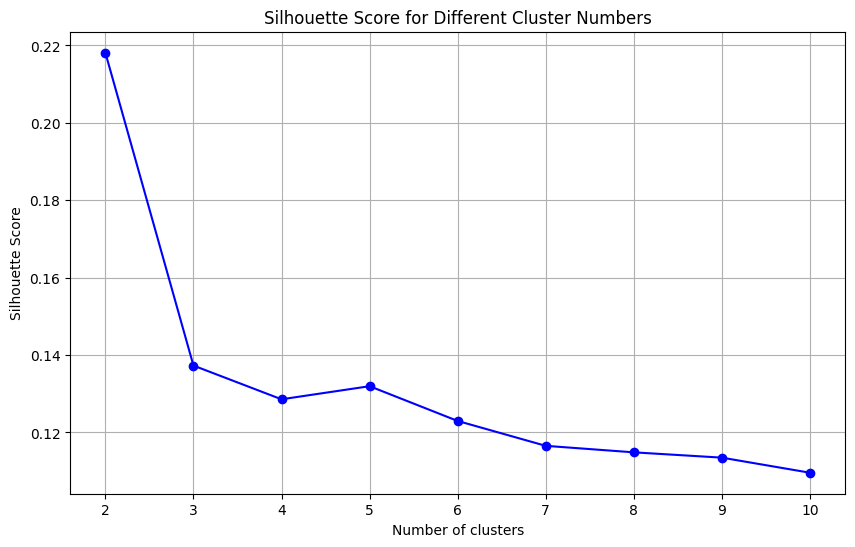

In [518]:
# Excluding the target variables and one-hot encoded categorical variables
numeric_features = [
    'Humidity Sensor (%)', 'CO2 Sensor (ppm)', 'EC Sensor (dS/m)', 
    'O2 Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 
    'Nutrient K Sensor (ppm)', 'pH Sensor', 'Water Level Sensor (mm)',
    'Light_Intensity_Clean'
]

# Scale features to have mean=0 and variance=1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Cluster Numbers')
plt.grid(True)
plt.show()

The resulting 4 clusters revealed distinct environmental regimes with different characteristics. When examining how temperature varies across these clusters, I found significant differences in temperature distributions, suggesting that these environmental clusters do indeed influence temperature conditions in meaningful ways.

Each cluster represents a different growing environment configuration, with distinct profiles of humidity, CO2, light intensity, and nutrient levels that correspond to different temperature ranges and variability patterns

Cluster sizes:
Cluster
0    11216
1    17868
2    16443
3    11948
Name: count, dtype: int64

Cluster feature means:
         Humidity Sensor (%)  CO2 Sensor (ppm)  EC Sensor (dS/m)  O2 Sensor (ppm)  Nutrient N Sensor (ppm)  Nutrient P Sensor (ppm)  Nutrient K Sensor (ppm)  pH Sensor  Water Level Sensor (mm)  Light_Intensity_Clean
Cluster                                                                                                                                                                                                                
0                  69.025633       1011.851997          1.640654         6.491619           171.265424                57.354939               207.696238       5.694330            27.633609               490.274964  
1                  67.453999       1261.338426          1.759840         7.038617           193.378610                63.404354               271.546172       6.279651            25.851699               563.168570  
2                  

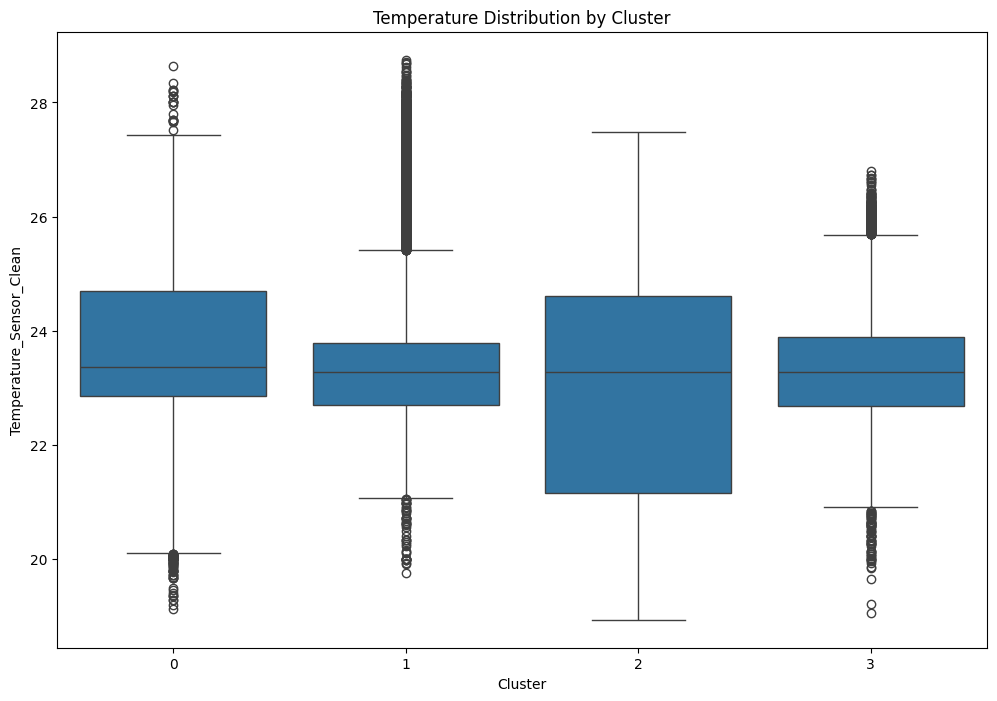

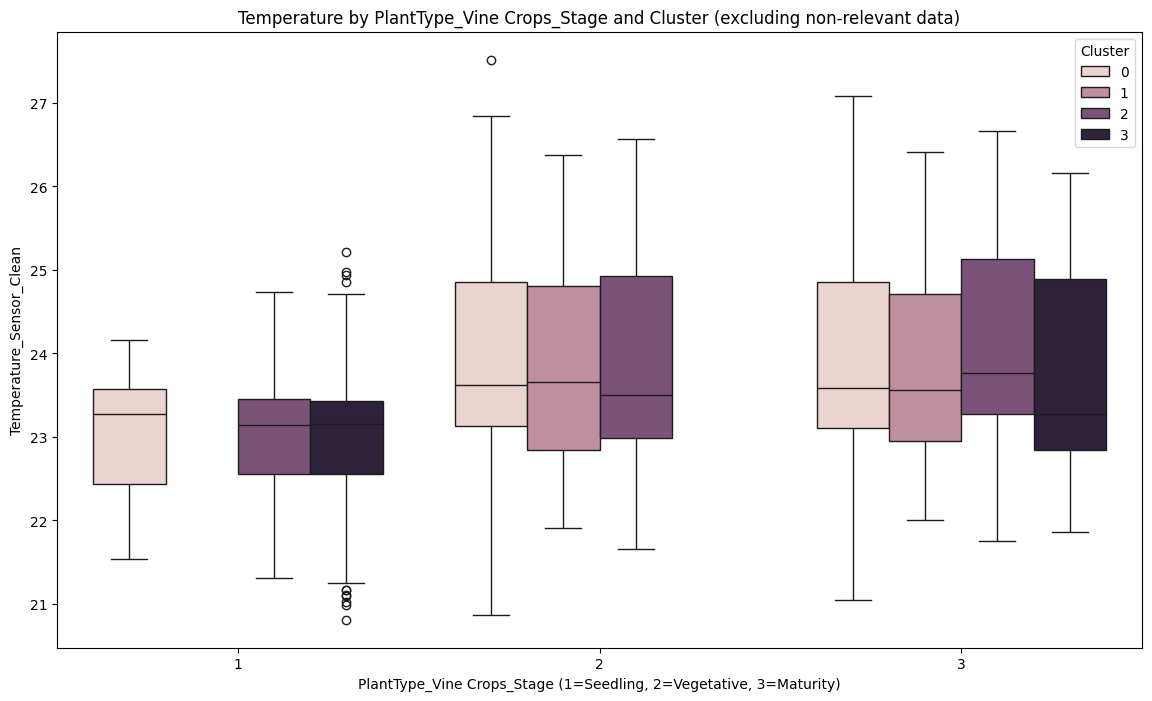

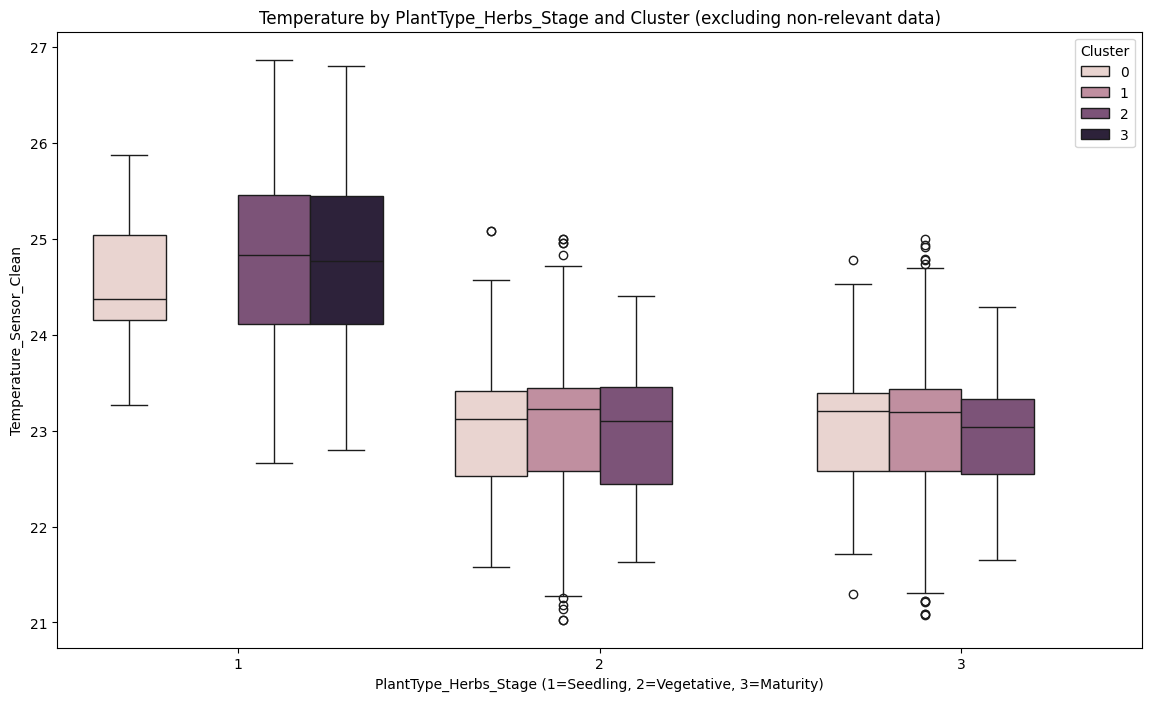

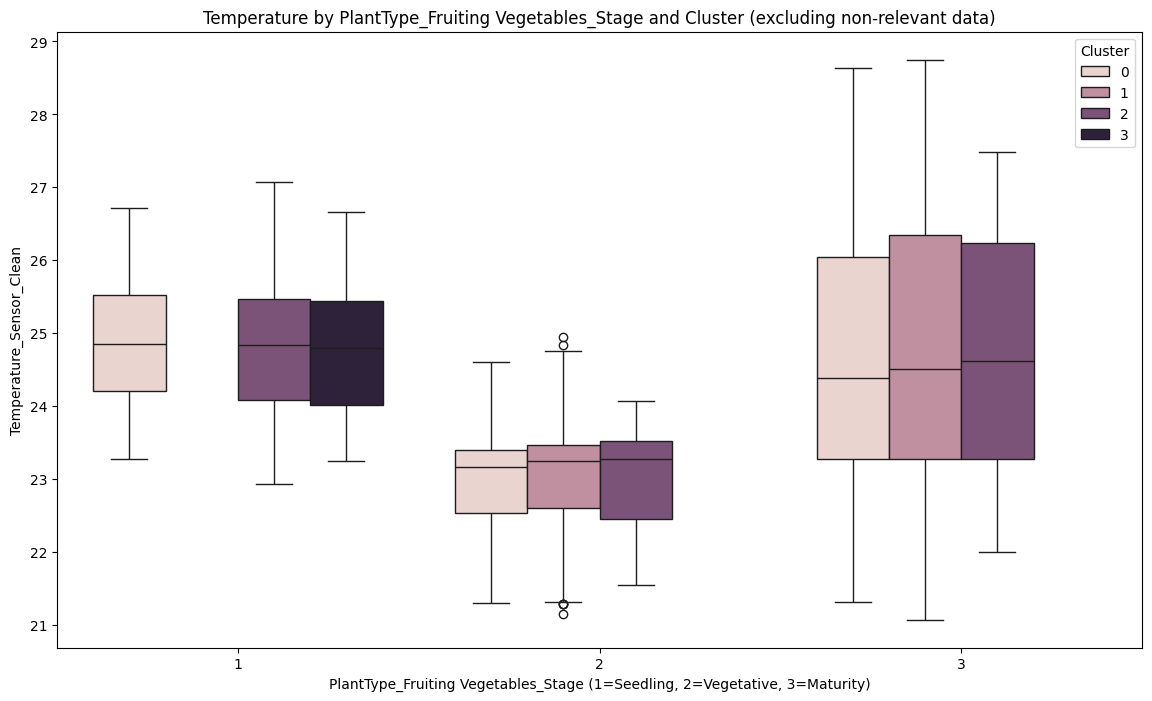

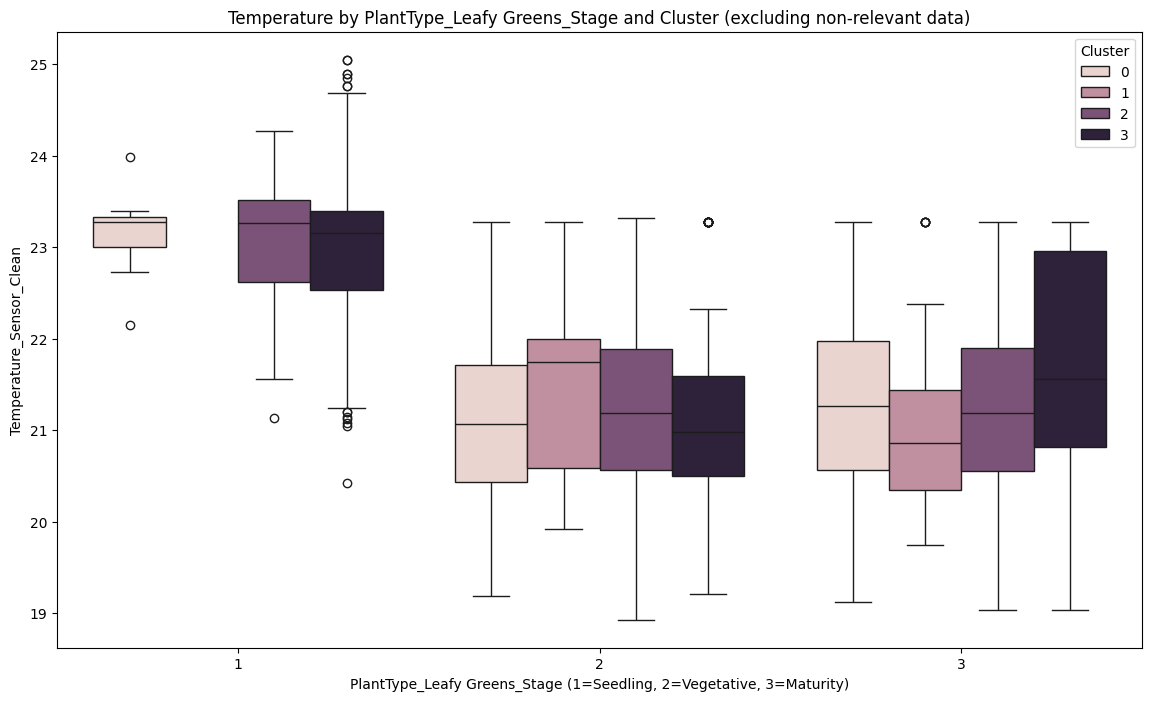

In [519]:
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Cluster size distribution
cluster_counts = df['Cluster'].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts)

# Examine feature means by cluster
cluster_means = df.groupby('Cluster')[numeric_features].mean()
print("\nCluster feature means:")
print(cluster_means)

# See how clusters relate to temperature
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='Temperature_Sensor_Clean', data=df)
plt.title('Temperature Distribution by Cluster')
plt.show()

# This adds cluster membership as a feature that can be used training later on
df_with_clusters = pd.get_dummies(df['Cluster'], prefix='Cluster')
df = pd.concat([df, df_with_clusters], axis=1)

# Analyze temperature by cluster and plant type-stage
plant_type_stage_cols = [col for col in df.columns if 'PlantType_' in col and '_Stage' in col]
for col in plant_type_stage_cols:
    df_filtered = df[df[col] > 0]    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=col, y='Temperature_Sensor_Clean', hue='Cluster', data=df_filtered)
    plt.title(f'Temperature by {col} and Cluster (excluding non-relevant data)')
    plt.xlabel(f'{col} (1=Seedling, 2=Vegetative, 3=Maturity)')
    plt.show()

Most interestingly, when analyzing how temperature varies by both cluster and plant type-stage, clear patterns emerged that weren't visible in the initial correlation analysis. The same plant type at the same growth stage can have markedly different temperature requirements depending on the environmental cluster, indicating important interaction effects.

This analysis reveals that the relationship between environmental factors and temperature is moderated by plant type and growth stage, explaining why simple correlation analysis was insufficient. These interactions will be crucial to incorporate in my predictive models.

# Feature Selection 

I approached feature selection by first setting up separate pipelines for my two prediction tasks. For temperature prediction, I carefully excluded the target variable and plant type-stage columns, ensuring I wasn't creating data leakage. I then trained a Random Forest regressor on the remaining features and used SelectFromModel with a 'median' threshold to identify the most important predictors.

In [520]:
# Prepare feature set for temperature prediction
X_temp = df.drop(['Temperature_Sensor_Clean', 'PlantType_Vine Crops_Stage', 
                  'PlantType_Herbs_Stage', 'PlantType_Fruiting Vegetables_Stage', 
                  'PlantType_Leafy Greens_Stage'], axis=1)
y_temp = df['Temperature_Sensor_Clean']

rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

# Select features based on importance
selector_temp = SelectFromModel(rf_temp, threshold='median', prefit=True)
X_temp_selected = X_temp.iloc[:, selector_temp.get_support()]
selected_features_temp = X_temp.columns[selector_temp.get_support()]

print("Selected features for temperature prediction:")
print(selected_features_temp.tolist())

Selected features for temperature prediction:
['Humidity Sensor (%)', 'CO2 Sensor (ppm)', 'EC Sensor (dS/m)', 'O2 Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'pH Sensor', 'Water Level Sensor (mm)', 'PrevPlant_Fruiting Vegetables', 'PrevPlant_Vine Crops', 'Light_Intensity_Clean', 'Cluster_2']


For the plant type-stage classification task, I first created a combined target variable by concatenating the plant type with its stage, resulting in values like 'Vine_1' or 'Leafy_3'. This gave me a single categorical target for my classification model. I then applied the same feature selection approach with a Random Forest classifier, using the median importance threshold to select the most relevant features. Interestingly, the temperature variable appeared among the selected features for classification, confirming my hypothesis that temperature strongly influences plant growth stages.

In [521]:
# Create Plant_Type_Stage column for classification 
conditions = [ 
    df['PlantType_Vine Crops_Stage'] > 0, 
    df['PlantType_Herbs_Stage'] > 0, 
    df['PlantType_Fruiting Vegetables_Stage'] > 0, 
    df['PlantType_Leafy Greens_Stage'] > 0 
] 
values = ['Vine_' + df['PlantType_Vine Crops_Stage'].astype(str), 
         'Herbs_' + df['PlantType_Herbs_Stage'].astype(str), 
         'Fruiting_' + df['PlantType_Fruiting Vegetables_Stage'].astype(str), 
         'Leafy_' + df['PlantType_Leafy Greens_Stage'].astype(str)]
df['Plant_Type_Stage'] = np.select(conditions, values, default='Unknown') 

# Classification feature selection - drop Cluster along with other columns
X_class = df.drop(['PlantType_Vine Crops_Stage', 'PlantType_Herbs_Stage', 
                  'PlantType_Fruiting Vegetables_Stage', 'PlantType_Leafy Greens_Stage', 
                  'Plant_Type_Stage', 'Cluster'], axis=1) 
y_class = df['Plant_Type_Stage'] 

# Fit Random Forest and select features in one step
rf_class = RandomForestClassifier(n_estimators=100, random_state=42) 
selector_class = SelectFromModel(rf_class, threshold='median') 
selector_class.fit(X_class, y_class) 
X_class_selected = X_class.iloc[:, selector_class.get_support()] 
selected_features_class = X_class.columns[selector_class.get_support()] 
print("Selected features for plant type-stage classification:") 
print(selected_features_class.tolist())

Selected features for plant type-stage classification:
['Humidity Sensor (%)', 'CO2 Sensor (ppm)', 'EC Sensor (dS/m)', 'O2 Sensor (ppm)', 'Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'pH Sensor', 'Water Level Sensor (mm)', 'Temperature_Sensor_Clean', 'Light_Intensity_Clean', 'Cluster_0', 'Cluster_1']


In [522]:
print(f"\nDataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns")
display(df.head())
df.to_sql('farm_data', conn, if_exists='replace', index=False)
conn.close()


Dataset dimensions: 57475 rows and 32 columns


,Humidity Sensor (%),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Location_Zone_A,Location_Zone_B,Location_Zone_C,Location_Zone_D,Location_Zone_E,Location_Zone_F,Location_Zone_G,PrevPlant_Fruiting Vegetables,PrevPlant_Herbs,PrevPlant_Leafy Greens,PrevPlant_Vine Crops,PlantType_Vine Crops_Stage,PlantType_Herbs_Stage,PlantType_Fruiting Vegetables_Stage,PlantType_Leafy Greens_Stage,Temperature_Sensor_Clean,Light_Intensity_Clean,Cluster,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Plant_Type_Stage
0,68.285,937,1.82,4,161.0,64.0,201.0,6.1,28.150346,0,0,0,1,0,0,0,0,1,0,0,3,0,0,0,23.34,454.0,0,True,False,False,False,Vine_3
1,63.140,938,2.13,6,161.0,53.0,215.0,6.5,31.000000,0,0,0,0,0,0,1,0,1,0,0,2,0,0,0,24.16,441.0,2,False,False,True,False,Vine_2
2,69.020,1246,1.21,8,228.0,79.0,292.0,6.4,26.000000,0,0,0,0,0,1,0,0,1,0,0,0,3,0,0,23.84,562.0,1,False,True,False,False,Herbs_3
3,68.765,1346,1.96,6,158.0,53.0,289.0,6.6,26.000000,0,0,0,0,0,0,1,0,1,0,0,0,0,2,0,22.61,651.0,1,False,True,False,False,Fruiting_2
4,68.850,812,2.76,5,61.0,19.0,168.0,5.5,28.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,22.88,144.0,3,False,False,False,True,Leafy_1
